## Problem 1.

This problem can be considered as Minimum cost flow:

We have 20 sources with positive inflows from left table, 20 sinks with negative -6 inflows, arcs with infinite capacities, which connect each source with each sink and arc costs equals to Euclidean distances between the tile centers. We will find a feasible flow that minimizes the total cost.

Formulation: 

$S$-sources, $T$-sinks,

$c_{ij} = \rho (s_i,t_j)$ - arc cost

$f_{ij}$ - flow from source i to sink j

$b_i$ - inflow of i-th source if $i\in S$ / of i-th sink if $i\in T$

Then we have mincost flow problem:

$$\min_{f} \sum_{i,j}^{} c_{i j}f_{i j}$$
subject to: 
$$ 0 \leq f_{ij} < \infty$$

$$b_j + \sum_{i \in I(j)}f_{ij} = \sum_{i \in O(j)}f_{ji} \Leftrightarrow \left\{\begin{matrix}
\forall j \in S: b_j = \sum_{i\in T}^{} f_{ji}
\\ 
\forall j \in T: b_j+ \sum_{i \in S}^{} f_{ij}=0
\end{matrix}\right.$$

In [23]:
import cvxpy as cvx 
import numpy as np

S = np.array([[5, 5, 10, 10, 10],
              [5, 5, 10, 20, 10],
              [0, 5, 5 , 10, 5 ],
              [0, 0, 0 , 5,  0 ]], dtype=int)

T = -6 * np.ones((4, 5))

b_sources = np.reshape(S, (20,1))
b_sinks = np.reshape(T, (20,1))

c = np.zeros((20, 20))
for j in range(20):
    for i in range(20):
        c[i][j] = np.sqrt((j%5-i%5)**2 + (j//5 - i//5)**2)
        
f = cvx.Variable(20, 20)
constraints = [b_sources==cvx.sum_entries(f, axis=1),  b_sinks + cvx.sum_entries(f, axis=0).T == 0, f >= 0]

objective = cvx.Minimize(cvx.trace(c * f))
prob = cvx.Problem(objective, constraints)
prob.solve(solver='GUROBI')
print ("status of solution:", prob.status)
print ("optimal cost:", prob.value)
print ("optimal flow:\n", f.value.astype(int))

status of solution: optimal
optimal cost: 95.49106383667822
optimal flow:
 [[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 6 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 0 2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 6 0 0 0 1 0 0 5 6 2 0 0]
 [0 0 0 0 0 0 0 0 0 6 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Problem 2.

Minimization problem:

$$min \quad \sum_{i=1}^FO_iy_i + \sum_{i=1}^F \sum_{j=1}^C A_{ij}x_{ij} $$
$$s.t. \quad \sum_{j=1}^Cx_{ij} \leq P_iy_i \quad \forall i$$
$$s.t. \quad \sum_{i=1}^Fx_{ij} = 1 \quad \forall j$$
$$x_{ij} \geq 0$$
$$y_{ij} \geq 0$$
$$x_{ij} \leq 1$$
$$y_{ij} \leq 1$$
where $O$ are facility oppening consts, $A$ are assignment consts, $x$ are customers, $y$ are facilites, and $P$ is capacity matix.

In [187]:
#Branch and bound optimization
class bnb_optimization:
    
    def __init__(self,F,C,N):
        
        self.x = cvx.Variable(F, C)
        self.y = cvx.Variable(F)
        self.obj = np.inf
        self.N = N
        self.iter_count = 0
        self.best_obj = np.inf
        self.opened_facilities = []
        self.assignments = []
        
    def make_constraints(self, F,C,assignment_costs, opening_costs,capacities): 
        constraints = [self.x >= 0, self.x <= 1, self.y >= 0, self.y <= 1]
        I_1 = np.identity(F)
        I_2 = np.identity(C) 
        for i in range(C):
            constraints.append(np.ones(F)*self.x*I_2[i] == 1)
        for j in range(F):
            constraints.append(I_1[j]*self.x*np.ones(C) <= capacities[j]*self.y[j])

        self.obj = cvx.Minimize(cvx.trace(self.x*assignment_costs.T) + opening_costs*self.y)
        return constraints 

    def solution(self, constraints):        
        prob = cvx.Problem(self.obj, constraints)
        sol = prob.solve()
        return sol
    
    def best_facility(self):
        error = np.inf
        fac = 0
        for (i,v) in enumerate(self.y.value):
            new_error = abs(v[0, 0] - 0.5)
            if (new_error <= error):
                fac = i
                error = new_error
        if (error > 0.49):
            return -1
        else:
            return fac
                                    
    def branch_and_bound(self, constraints):
    
        solutions = []
        self.solution(constraints)
        for i in range(self.N):
        
            fac = self.best_facility()
            for j in range(2):
                next_constraints = constraints + [self.y[fac] == j]
                objective = self.solution(constraints)
                if objective > self.best_obj:
                    continue
                fac = self.best_facility()
                if fac == -1:
                    self.best_obj = objective
                    self.opened_facilities = self.y.value
                    self.assignments = self.x.value
        
                else:
                    solutions.append(next_constraints)
            if (len(solutions) == 0):
                return self.best_obj, self.opened_facilities, self.assignments
            constraints = solutions.pop()
            objective = self.solution(constraints)

In [188]:
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from gurobi import GRB
import gurobi as grb

%matplotlib inline

class Problem:
    def __init__(self, C=20, F=15):
        self.C = C
        self.F = F
        
        self.clients = np.random.rand(2, C)    # client positions
        self.facilities = np.random.rand(2, F) # facility positions

        # maximum number of clients per facility
        self.capacities = np.ones((F,), dtype=np.int32)*4;

        # assignment cost is defined as the squared distance between a client and a facility
        dx = \
            np.matlib.repmat(self.clients[0,:],F,1) - \
            np.matlib.repmat(self.facilities[0,:],C,1).transpose();
        dy = \
            np.matlib.repmat(self.clients[1,:],F,1) - \
            np.matlib.repmat(self.facilities[1,:],C,1).transpose();

        self.assignment_costs = 3*(dx*dx + dy*dy);

        self.opening_costs = np.ones((F,));
    
    def assign_random_capacities(self):
        """
        Assign more or less random capacities to facilities.
        
        This is one of the possible ways to change the problem configuration.
        In other words, use this function when testing your solution!
        """
        while True:
            self.capacities = \
                np.random.randint(2*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
    
    def assign_random_opening_costs(self):
        """
        Assign more or less random opening costs to facilities.
        
        Same as above -- use this for your report.
        """
        # could be float, but let it be simple
        self.opening_costs = \
            np.random.randint((self.C+self.F-1) // self.F, size=self.F) + 1
    
    def plot(self, y, assignments, fig=plt):
        """
        Plot the given solution (y, assignments)
        
        Arguments:
        y, assignments -- see Problem.objective().
        fig            -- an instance of matplotlib.axes._axes.Axes to draw on.
                          Also, can be matplotlib.pyplot, in this case use the default Axes.
                          This is useful to compare your results (see "Results comparison" section).
        """
        
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)
        
        for cli,fac in enumerate(assignments):
            fig.plot([self.clients[0,cli], self.facilities[0,fac]], \
                     [self.clients[1,cli], self.facilities[1,fac]], c=(.7,.7,.7))
            
        fig.scatter(self.clients[0,:], self.clients[1,:], s=15.0, c=assignments, \
                    vmin=0, vmax=self.F-1)
        
        fig.scatter(self.facilities[0,:], self.facilities[1,:], s=54.0, \
                    c=range(self.F), linewidth = [1*el for el in y])
        
    def objective(self, y, assignments):
        """
        Return objective function value given a solution.
        If the solution is infeasible, return infinity.
        
        Arguments:
        y           -- a binary 1D array of size F. y[i] is 1 iff i-th facility is open.
        assignments -- an integer 1D array of size C. assignments[i] is index of facility
                       that i-th client is assigned to.
        """
        assert len(y) == self.F
        assert len(assignments) == self.C
        
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)
        
        retval = sum(is_opened*opening_cost \
                     for is_opened, opening_cost in zip(y, self.opening_costs))
        
        assignment_counts = np.zeros_like(y)
        
        for cli,fac in enumerate(assignments):
            if not y[fac]:
                return np.inf
            else:
                retval += self.assignment_costs[fac,cli]
                assignment_counts[fac] += 1
                
        if any(assignment_counts > self.capacities):
            return np.inf
            
        return retval
        
    def solve_gurobi(self, verbose=False):
        """
        Solve the problem using mixed integer program solver.
        Return `y, assignments` (see Problem.objective() docstring for format).
        
        Arguments:
        verbose -- controls Gurobi output.
        """
        m = grb.Model("facility")

        y = []
        for i_f in range(self.F):
            y.append(m.addVar(vtype=GRB.BINARY))

        x = []    
        for i_f in range(self.F):
            x.append([])
            for i_c in range(self.C):
                x[i_f].append(m.addVar(vtype=GRB.BINARY))

        # the objective is to minimize the total fixed and variable costs
        m.modelSense = GRB.MINIMIZE

        # update model to integrate new variables
        m.update()

        # set optimization objective - minimize sum of fixed costs
        obj_summands = []
        for i_f in range(self.F):
            obj_summands.append(self.opening_costs[i_f]*y[i_f])

        for i_f in range(self.F):
            for i_c in range(self.C):
                obj_summands.append(self.assignment_costs[i_f][i_c]*x[i_f][i_c])

        m.setObjective(grb.quicksum(obj_summands))

        # set constraints
        for i_c in range(self.C):
            client_constr_summands = [x[i_f][i_c] for i_f in range(self.F)]
            m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)

        for i_f in range(self.F):        
            facility_constr_summands = [x[i_f][i_c] for i_c in range(self.C)]
            m.addConstr(sum(facility_constr_summands), \
                        GRB.LESS_EQUAL, self.capacities[i_f]*y[i_f])       

        for i_f in range(self.F):        
            for i_c in range(self.C):
                m.addConstr(x[i_f][i_c], GRB.LESS_EQUAL, y[i_f])

        # optimize
        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        
        facilities_opened = [y[i_f].X for i_f in range(self.F)]
        clients_assignment = \
            [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f][i_c].X != 0]
        
        return np.array(facilities_opened), np.array(clients_assignment)
    def solve_bnb(self, N):
        B = bnb_optimization(self.F, self.C, N)
        constraints = B.make_constraints(self.F, self.C, self.assignment_costs, self.opening_costs,self.capacities)
        p, y, x = B.branch_and_bound(constraints)
        #print (p)
        #print (y)
        #print (x[2,2])
        facilities_opened = [y[i_f,0] for i_f in range(self.F)]
        clients_assignment = [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f,i_c]>0.001] 
        return p, np.array(facilities_opened), np.array(clients_assignment)

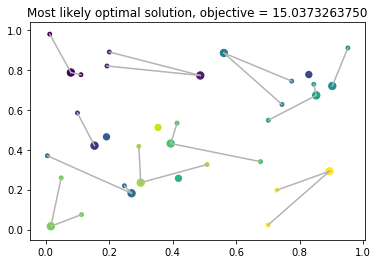

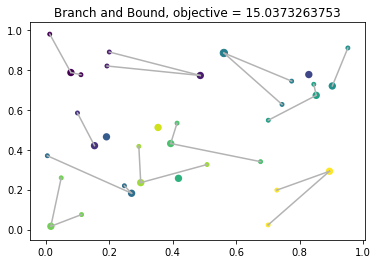

In [189]:
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()
ax = plt.figure().gca()
y1, assignments1 = problem.solve_gurobi()
problem.plot(y1, assignments1, ax)
ax.set_title('Most likely optimal solution, objective = %.10f' % problem.objective(y1, assignments1))

ax = plt.figure().gca()
p, y2, assignments2 = problem.solve_bnb(50)
#print (y1)
#print (assignments1)
#print (y2)
#print (assignments2)
problem.plot(y2, assignments2, ax)
ax.set_title('Branch and Bound, objective = %.10f'% p)

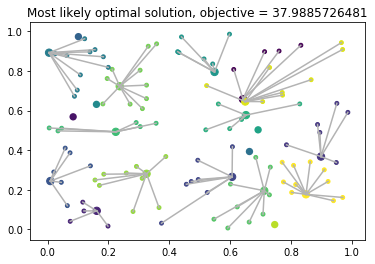

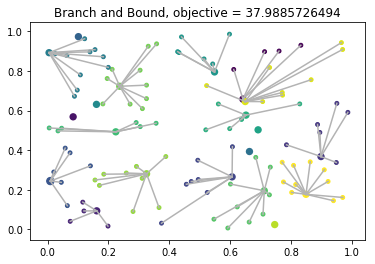

In [191]:
np.random.seed(42)

problem = Problem(C=100, F=20)
problem.assign_random_capacities()
problem.assign_random_opening_costs()
ax = plt.figure().gca()
y1, assignments1 = problem.solve_gurobi()
problem.plot(y1, assignments1, ax)
ax.set_title('Most likely optimal solution, objective = %.10f' % problem.objective(y1, assignments1))

ax = plt.figure().gca()
p, y2, assignments2 = problem.solve_bnb(100)
#print (y1)
#print (assignments1)
#print (y2)
#print (assignments2)
problem.plot(y2, assignments2, ax)
ax.set_title('Branch and Bound, objective = %.10f'% p)

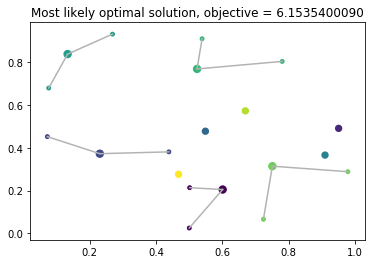

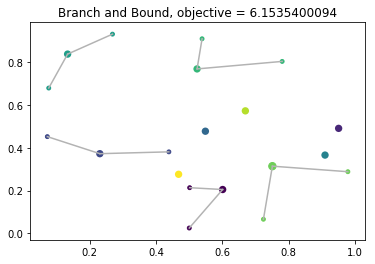

In [192]:
np.random.seed(7)

problem = Problem(C=10, F=10)
problem.assign_random_capacities()
problem.assign_random_opening_costs()
ax = plt.figure().gca()
y1, assignments1 = problem.solve_gurobi()
problem.plot(y1, assignments1, ax)
ax.set_title('Most likely optimal solution, objective = %.10f' % problem.objective(y1, assignments1))

ax = plt.figure().gca()
p, y2, assignments2 = problem.solve_bnb(20)
#print (y1)
#print (assignments1)
#print (y2)
#print (assignments2)
problem.plot(y2, assignments2, ax)
ax.set_title('Branch and Bound, objective = %.10f'% p)

## Problem 3.

In [216]:
np.random.seed(7)
N = 20
a = np.random.rand(N, N)
f = np.tril(a) + np.tril(a, -1).T
for i in range(N):
    f[i, i] = 0
    
x = cvx.Bool(N, N)
constraints = [cvx.trace(x) == 0,
              x == x.T,
              cvx.sum_entries(x, axis=1) == 1]

obj = cvx.Maximize(cvx.sum_entries(cvx.mul_elemwise(f, x)))

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI')
print ("status of solution:", prob.status)
print ("optimal value:", prob.value)
print ("optimal variables: \n", x.value.astype(np.int32))

status of solution: optimal
optimal value: 18.31026443104919
optimal variables: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


{0: <matplotlib.text.Text at 0x7f75931c4048>,
 1: <matplotlib.text.Text at 0x7f7593462080>,
 2: <matplotlib.text.Text at 0x7f7593462fd0>,
 3: <matplotlib.text.Text at 0x7f75934620b8>,
 4: <matplotlib.text.Text at 0x7f75936cabe0>,
 5: <matplotlib.text.Text at 0x7f75936caa58>,
 6: <matplotlib.text.Text at 0x7f75936ca748>,
 7: <matplotlib.text.Text at 0x7f75936cada0>,
 8: <matplotlib.text.Text at 0x7f7594489e80>,
 9: <matplotlib.text.Text at 0x7f759369acf8>,
 10: <matplotlib.text.Text at 0x7f759369af28>,
 11: <matplotlib.text.Text at 0x7f759369a128>,
 12: <matplotlib.text.Text at 0x7f759369a7f0>,
 13: <matplotlib.text.Text at 0x7f7593a019b0>,
 14: <matplotlib.text.Text at 0x7f7593a01c88>,
 15: <matplotlib.text.Text at 0x7f7593d4cda0>,
 16: <matplotlib.text.Text at 0x7f7593d4c710>,
 17: <matplotlib.text.Text at 0x7f7593d4c4e0>,
 18: <matplotlib.text.Text at 0x7f7593d4ca90>,
 19: <matplotlib.text.Text at 0x7f7593d5b710>}

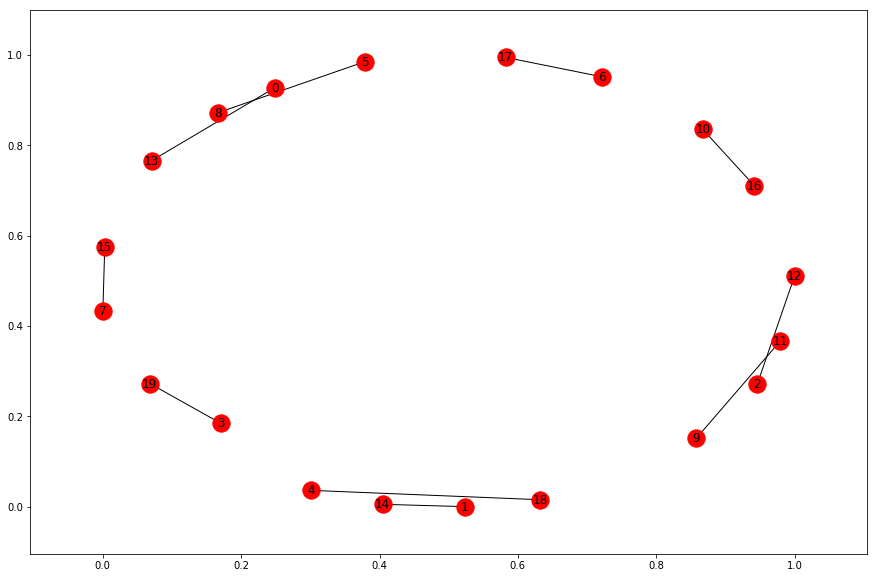

In [217]:
import networkx as nx
G = nx.Graph(x.value)

plt.figure(figsize=(15,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

In [218]:
x = cvx.Variable(N, N)
constraints = [x >= 0,
               x <= 1,
               cvx.trace(x) == 0,
               x == x.T,
               cvx.sum_entries(x, axis=1) == 1]

obj = cvx.Maximize(cvx.sum_entries(cvx.mul_elemwise(f, x)))

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI')
print ("optimal value:", prob.value)

optimal value: 18.31026443104919


{0: <matplotlib.text.Text at 0x7f7593788f60>,
 1: <matplotlib.text.Text at 0x7f7593790978>,
 2: <matplotlib.text.Text at 0x7f7593790d30>,
 3: <matplotlib.text.Text at 0x7f7593798128>,
 4: <matplotlib.text.Text at 0x7f7593798438>,
 5: <matplotlib.text.Text at 0x7f75937987f0>,
 6: <matplotlib.text.Text at 0x7f7593798ba8>,
 7: <matplotlib.text.Text at 0x7f7593798f60>,
 8: <matplotlib.text.Text at 0x7f759379a358>,
 9: <matplotlib.text.Text at 0x7f759379a710>,
 10: <matplotlib.text.Text at 0x7f759379aac8>,
 11: <matplotlib.text.Text at 0x7f759379ae80>,
 12: <matplotlib.text.Text at 0x7f759379b278>,
 13: <matplotlib.text.Text at 0x7f759379b630>,
 14: <matplotlib.text.Text at 0x7f759379b9e8>,
 15: <matplotlib.text.Text at 0x7f759379bda0>,
 16: <matplotlib.text.Text at 0x7f759378e198>,
 17: <matplotlib.text.Text at 0x7f759378e550>,
 18: <matplotlib.text.Text at 0x7f759378e908>,
 19: <matplotlib.text.Text at 0x7f759378ecc0>}

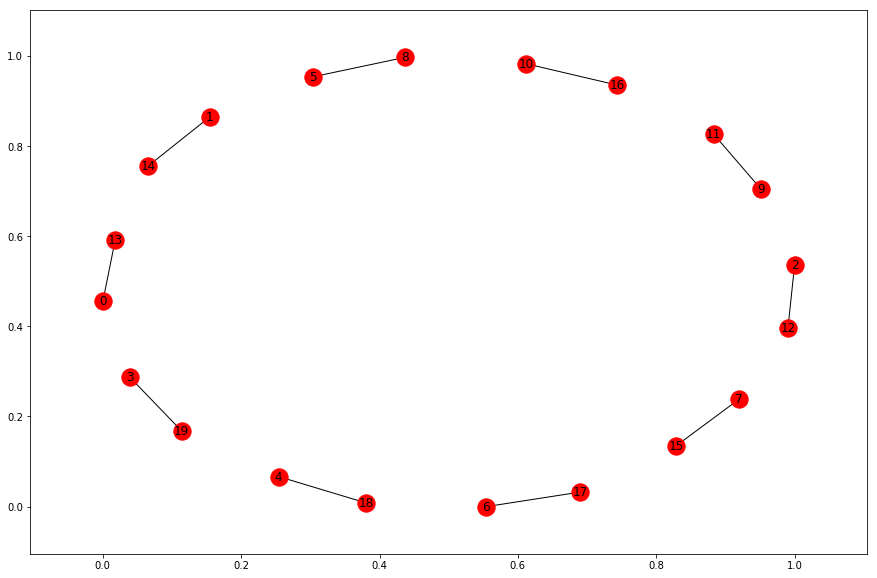

In [219]:
%matplotlib inline

X = x.value.copy()
G = nx.Graph(X)

plt.figure(figsize=(15,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

In [2]:
import numpy as np
n=5
ar = np.hstack((range(n), range(-n+1, 0)))
diff_1, diff_2 = np.meshgrid(ar, ar)

In [3]:
ar

array([ 0,  1,  2,  3,  4, -4, -3, -2, -1])

In [6]:
diff_2

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4],
       [-4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [7]:
diff_1

array([[ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1],
       [ 0,  1,  2,  3,  4, -4, -3, -2, -1]])